This is inspired by implementation 

https://github.com/tdeboissiere/DeepLearningImplementations/blob/master/WassersteinGAN/src/model/models_WGAN.py

https://github.com/tdeboissiere/DeepLearningImplementations/blob/master/WassersteinGAN/src/model/train_WGAN.py

In [1]:
import numpy as np
import random

from keras.layers import Input,merge
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Cropping2D, Convolution2D, Deconvolution2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D
import keras
import keras.backend as K
from keras.models import Model

from tqdm import tqdm


Using Theano backend.
Using gpu device 0: GeForce GTX 950 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)
/home/yiyuezhuo/anaconda3/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
from sklearn.externals import joblib
import numpy as np

def load_train(filename, dim_ordering = 'th', debug = True, bgr_to_rgb = False) :
    # Expects files to be loaded and pickled as RGB image 
    X = joblib.load(filename)['X']

    # Scale color range from (0, 1) to (-1, 1)
    X = X * 2 - 1
    assert np.min(X) >= -1.0 and np.max(X) <= 1.0
    if debug :
        print("Color range: ", np.min(X), np.max(X))
    
    if bgr_to_rgb :
        X = X[:, :, :, [2, 1, 0]]
    
    assert X.shape[-1] == 3
    if dim_ordering == 'th' :
        # Change dim_ordering from TF (count_images, height, width, 3) to theano (count_images, 3, height, width)
        X = np.swapaxes(X, 2, 3)
        X = np.swapaxes(X, 1, 2)
    elif dim_ordering == 'tf' :
        pass
    else :
        raise ValueError('Dim ordering %s is not supported' % dim_ordering)
    
    if debug :
        print('Shape:', X.shape)
    
    return X

In [5]:
%%time

X = load_train('video.frame.dump')


Color range:  -1.0 1.0
Shape: (12300, 3, 72, 128)
CPU times: user 2.75 s, sys: 4.49 s, total: 7.24 s
Wall time: 44.4 s


In [3]:
def generator_block(input_node, input_shape, leaku_relu_alpha) :    
    channels, height, width = input_shape
    output_shape = (None, channels // 2, height * 2 + 2, width * 2 + 2)  
    
    block = Deconvolution2D(
        output_shape[1], 
        4, 4, 
        output_shape = output_shape, 
        border_mode='valid', 
        init='glorot_uniform', 
        subsample = (2, 2),
        bias = False
    )(input_node)
    block = Cropping2D(((1, 1), (1, 1)))(block)
    block = BatchNormalization(mode = 2)(block)
    block = LeakyReLU(leaku_relu_alpha)(block)

    return block


def build_generator(initial_size = (3, 4), channels_count = 22 * 22, leaky_relu_alpha = 0.2) :
    generator_input = Input(shape=[100])
    
    initial_height, initial_width = initial_size
    
    H = Dense(channels_count * initial_height * initial_width)(generator_input)
    H = BatchNormalization(mode = 2)(H)
    H = LeakyReLU(0.2)(H)
    H = Reshape([channels_count , initial_height, initial_width] )(H) # nch

    # 3 layers result in x16 increased picture size, (3, 4) -> (9,16) -> (72, 128)

    H = Deconvolution2D(channels_count , 5,7,
                        output_shape = (None,channels_count,9,16), 
                        border_mode='valid', 
                        init='glorot_uniform', 
                        subsample = (2, 3))(H)
    H = BatchNormalization(mode = 2)(H)
    H = LeakyReLU(leaky_relu_alpha)(H)
    
    H = generator_block(H, (channels_count // 2, initial_height * 3, initial_width * 4), leaky_relu_alpha)
    H = generator_block(H, (channels_count // 4 , initial_height * 3 * 2, initial_width * 4 *2), leaky_relu_alpha)
    H = generator_block(H, (channels_count // 8 , initial_height * 3 * 4, initial_width * 4 * 4), leaky_relu_alpha)
    #H = generator_block(H, (channels_count // 8 , initial_height * 8, initial_width * 8), leaky_relu_alpha)

    H = Convolution2D(channels_count // 32, 3, 3, border_mode='same', init='glorot_uniform')(H)
    H = BatchNormalization(mode = 2)(H)
    H = LeakyReLU(leaky_relu_alpha)(H)

    H = Convolution2D(3, 1, 1, border_mode='same', init='glorot_uniform')(H)
    generator_output = Activation('tanh')(H)

    generator = Model(generator_input, generator_output)
    generator_output_shape = (3, initial_height *3* 8, initial_width *4* 8)

    return generator, generator_input, generator_output_shape


def build_discriminator(input_shape, discriminator_base_channels = 64, leaky_relu_alpha = 0.2, dropout_rate = 0.25) :
    
    discriminator_input = Input(shape = input_shape)
    
    H = Convolution2D(discriminator_base_channels * 3, 5, 5, subsample=(2, 2), border_mode = 'same', bias=False)(discriminator_input)
    H = BatchNormalization(mode = 2)(H)
    H = LeakyReLU(leaky_relu_alpha)(H)
    
    H = Convolution2D(discriminator_base_channels * 4, 5, 5, subsample=(2, 2), border_mode = 'same', bias=False)(H)
    H = BatchNormalization(mode = 2)(H)
    H = LeakyReLU(leaky_relu_alpha)(H)
    
    H = Convolution2D(discriminator_base_channels * 5, 3, 3, subsample=(2, 2), border_mode = 'same', bias=False)(H)
    H = BatchNormalization(mode = 2)(H)
    H = LeakyReLU(leaky_relu_alpha)(H)
    
    H = Convolution2D(discriminator_base_channels * 6, 5, 7, subsample=(2, 3), border_mode = 'valid', bias=False)(H)
    H = BatchNormalization(mode = 2)(H)
    H = LeakyReLU(leaky_relu_alpha)(H)

    H = Convolution2D(1, 3, 3, border_mode = 'same', bias=False)(H)
    
    '''
    H = BatchNormalization(mode = 2)(H)
    H = LeakyReLU(leaky_relu_alpha)(H)
    H = Dropout(dropout_rate)(H)
    
    
    H = Flatten()(H)
    
    H = Dense(discriminator_base_channels * 2)(H)
    H = LeakyReLU(0.2)(H)
    discriminator_output = Dense(2, activation='softmax')(H)
    '''
    
    H = GlobalAveragePooling2D()(H)
    discriminator = Model(discriminator_input, H)
    
    return discriminator, H
    
    
def make_trainable(model, mode):
    model.trainable = mode
    for layer in model.layers:
        layer.trainable = mode
    
def wasserstein(y_true, y_pred):

    # return K.mean(y_true * y_pred) / K.mean(y_true)
    return -K.mean(y_true * y_pred)

    
def build_models(
    debug = True, 
    generator_optimizer = SGD(lr=1e-2), 
    discriminator_optimizer = SGD(lr=1e-2),
    discriminator_dropout_rate = 0.25,
    generator_initial_size = (3, 4),
) :
    generator, generator_input, generator_output_shape = build_generator(generator_initial_size) 
    generator.compile(loss='mse', optimizer = generator_optimizer)

    if debug :
        generator.summary()
    
    input_shape = generator_output_shape
    discriminator, discriminator_output = build_discriminator(input_shape, dropout_rate = discriminator_dropout_rate)
    discriminator.compile(loss = wasserstein, optimizer = discriminator_optimizer)
    if debug :
        discriminator.summary()
        
    # Freeze weights in the discriminator for stacked training
    make_trainable(discriminator, False)
    
    gan_input = Input(shape=[100])
    H = generator(gan_input)
    gan_output = discriminator(H)
    gan = Model(gan_input, gan_output)
    gan.compile(loss = wasserstein, optimizer=generator_optimizer)
    if debug :
        gan.summary()
        
    return generator, discriminator, gan, generator_optimizer, discriminator_optimizer

In [4]:
generator, discriminator, gan, generator_optimizer, discriminator_optimizer = build_models()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 5808)          586608      input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 5808)          23232       dense_1[0][0]                    
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 5808)          0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [6]:
def noise_generator(batch, size = 100) :
    # Normal (0, 1) noise instead of uniform as in original DCGAN 
    return np.random.normal(0, 1, size=[batch,100])

clamp_lower = -1.0
clamp_upper =  1.0

def weight_clip(model):
    for l in model.layers:
        weights = l.get_weights()
        weights = [np.clip(w, clamp_lower, clamp_upper) for w in weights]
        l.set_weights(weights)


In [7]:
# Pre-train the discriminator network ...
def pretrain_discriminator(discriminator, X, pretrain_size = 1000) :
    train_ids = random.sample(range(0, X.shape[0]), pretrain_size)
    X_pretrain = X[train_ids, :, :, :]

    noise = noise_generator(pretrain_size)
    generated_images = generator.predict(noise)
    X_pretrain = np.concatenate([X_pretrain, generated_images])

    y = np.zeros([pretrain_size * 2, 1])
    # Real images
    y[:pretrain_size, 0] = 1
    # Generated
    y[pretrain_size:, 0] = -1

    make_trainable(discriminator, True)
    weight_clip(discriminator)
    
    discriminator.fit(X_pretrain, y, nb_epoch=2, batch_size=32, verbose = 0)
    return discriminator.evaluate(X_pretrain, y, verbose = 0)

In [8]:
%%time

pretrain_discriminator(discriminator, X)


CPU times: user 1min 10s, sys: 11.7 s, total: 1min 22s
Wall time: 1min 45s


76773760434.175995

In [9]:
def history_replay(history, batch_size) :
    assert batch_size % len(history) == 0
    
    history_batch = []
    for history_images in history :
        images_count = batch_size // len(history)
        history_batch.append(
            history_images[
                np.random.randint(0, history_images.shape[0], size = images_count)
            ]
        )
    history_batch = np.concatenate(history_batch)
    return history_batch


def train_discriminator(discriminator, history, X, batch_size, losses) :
    
    make_trainable(discriminator, True)
    weight_clip(discriminator)

    X_fake = history_replay(history, batch_size)
    y = np.zeros([batch_size, 1])
    
    # Soft-noisy labels
    #y[:, 0] = np.random.uniform(0.7, 1.0, size=[batch_size])
    #y[:, 1] = -y[:, 0] + 1.0
    y[:,0] = np.random.uniform(-1.0,-0.7, size = [batch_size])
    
    loss_fake = discriminator.train_on_batch(X_fake, y)
    
    X_real = X[np.random.randint(0, X.shape[0],size = batch_size),:,:,:]    
    y = np.zeros([batch_size, 1])
    #y[:, 1] = np.random.uniform(0.7, 1.2, size=[batch_size])
    #y[:, 0] = -y[:, 1] + 1.0
    y[:, 0] = np.random.uniform(0.7, 1.0, size=[batch_size])
    
    loss_real  = discriminator.train_on_batch(X_real, y)
    for name, loss in [
        #('discriminator accuracy real', accuracy_real),
        #('discriminator accuracy fake', accuracy_fake),
        ('discriminator loss real', loss_real),
        ('discriminator loss fake', loss_fake),
    ] :
        losses[name].append(loss)

        
def train_generator(gan, generator, batch_size, losses) :
    g_loss = 0
    make_trainable(discriminator, False)
    noise = noise_generator(batch_size)
    #y = np.zeros([batch_size,  2])
    #y[:, 1] = 1
    y = np.ones([batch_size,  1])

    loss = gan.train_on_batch(noise, y)
    losses['generator loss'].append(loss)

!mkdir samples
!mkdir samples/tiled-48
!mkdir samples/tiled-48/shaking
        
rows, columns = 9, 9

def save_models(generator, discriminator, gan) :
    generator.save('generator.model')
    discriminator.save('discriminator.model')
    gan.save('gan.model')
    
def train_gan(discriminator, gan, generator, losses, epoch_count = 50000, plot_frequency = 50, render_frequency = 1000, 
              batch_size = 32, history_length = 8, train_dis = True, train_gen = True) :
    # History replay-like heuristic used to train discriminator 
    history = []
    for i in range(history_length - 1) : 
        noise = noise_generator(batch_size)
        generated_images = generator.predict(noise)    
        history.append(generated_images)
        
    for epoch in tqdm(range(epoch_count)) :
        noise_gen = np.random.uniform(0, 1, size=[batch_size,100])
        generated_images = generator.predict(noise_gen)
        history.append(generated_images)
        
        if train_dis:
            train_discriminator(discriminator, history, X, batch_size, losses)
        if train_gen:
            train_generator(gan, generator, batch_size, losses)

        history.pop(random.choice(range(history_length)))
        
        if epoch % plot_frequency == 0 :
            plot_loss(losses)
            plot_generator()
            
        if epoch % render_frequency == 0 :
            '''
            images = image_shaking(generator, images_count = rows, shakes_count = columns, noise = fixed_noise[:rows])
            save_tiled(
                images, 
                'samples/tiled-48/shaking/epoch-%d.png' % epoch, 
                rows, 
                columns,
                image_size = (128, 72)
            )
            '''
            save_models(generator, discriminator, gan)

mkdir: cannot create directory ‘samples’: File exists
mkdir: cannot create directory ‘samples/tiled-48’: File exists
mkdir: cannot create directory ‘samples/tiled-48/shaking’: File exists


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

import pandas as pd
#pandas used to efficiently calculate rolling_mean

def plot_loss(
    losses, 
    names = (
        'discriminator loss real',
        'discriminator loss fake',
        'generator loss',
    ),
    average_window = 100,
):
    display.clear_output(wait = True)
    display.display(plt.gcf())
    plt.figure(figsize=(12, 8))
    for name in names :
        plt.plot(
            pd.rolling_mean(pd.Series(losses[name]), window = average_window).values, 
            label = name
        )
    
    plt.legend()
    plt.show()
    
def plot_grid(images, dimensions = (5, 5), figsize=(10, 10)) :
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dimensions[0], dimensions[1], i + 1)
        
        # (-1, 1) color range to (0, 1)
        image = (images[i, :, :, :] + 1.0) * 0.5
        
        plt.imshow(image)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

plot_dimensions = (5, 5)
plot_image_count = np.prod(plot_dimensions)
fixed_noise = noise_generator(plot_image_count)

def plot_generator(n_images = plot_image_count, dimensions = plot_dimensions, figsize = (10, 10), fixed_set = True):
    if fixed_set :
        noise = fixed_noise
    else :
        noise = noise_generator(n_ex)
        
    generated_images = generator.predict(noise)
    
    # Convert to (height, width, RGB)
    generated_images = np.swapaxes(generated_images, 1, 2)
    generated_images = np.swapaxes(generated_images, 2, 3)
    
    plot_grid(generated_images, plot_dimensions, figsize)

In [11]:
plot_dimensions = (5, 5)
plot_image_count = np.prod(plot_dimensions)

def plot_real(X, images_count = plot_image_count, dimensions = plot_dimensions, figsize=(10,10)):
    images_ids = np.random.randint(0, X.shape[0], images_count)
    images = X[images_ids, :, :, :][:, :, :, :]
    
    
    images = np.swapaxes(images, 1, 2)
    images = np.swapaxes(images, 2, 3)
    
    plot_grid(images, dimensions = dimensions)

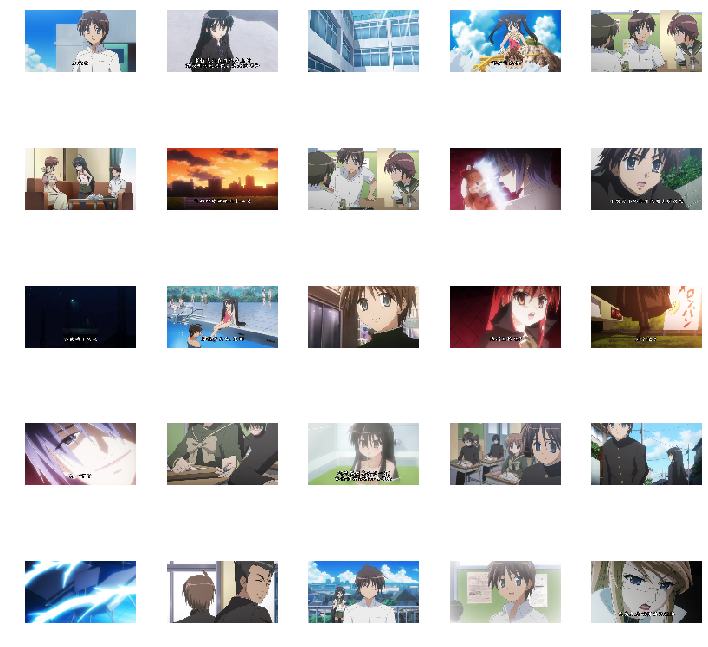

In [12]:
plot_real(X,figsize = (16,16))

In [13]:
def swap_dimensions(images) :
    images = np.swapaxes(images, 1, 2)
    images = np.swapaxes(images, 2, 3)
    return images

def shake(v, rate = 0.1) :
    return v * np.random.uniform(1.0 - rate, 1.0 + rate, size=100)


def image_shaking(generator, images_count = 9, shakes_count = 9, noise = None) :
    if noise is None :
        noise = noise_generator(images_count)
    
    input_vectors = []
    for i in range(images_count) :        
        for j in range(shakes_count) :
            original = np.array(noise[i])
            if i > 0 :
                shaked = shake(original, 0.3)
            else :
                shaked = original
                
            input_vectors.append(shaked)
    
    input_vectors = np.stack(input_vectors)
    generated_images = generator.predict(input_vectors, batch_size = images_count * shakes_count)
    generated_images = np.swapaxes(generated_images, 1, 2)
    generated_images = np.swapaxes(generated_images, 2, 3)
    generated_images = (generated_images + 1.0) * 0.5
        
    return generated_images

In [14]:
losses = dict([
    (name, []) for name in (
        'discriminator loss real',
        'discriminator loss fake',
        'generator loss',
    )
])
losses


{'discriminator loss fake': [],
 'discriminator loss real': [],
 'generator loss': []}

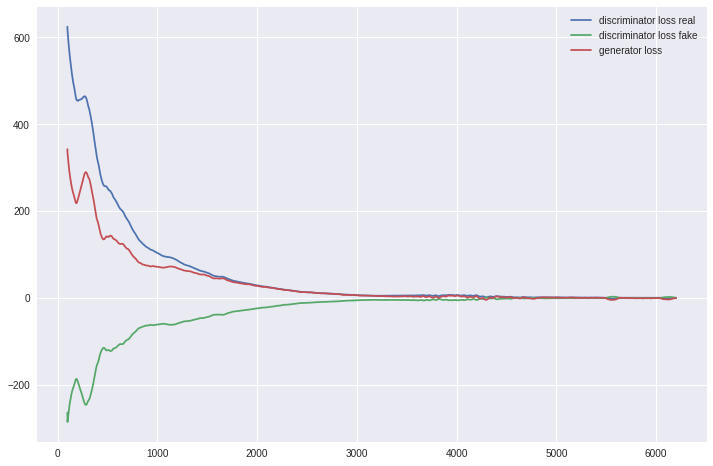

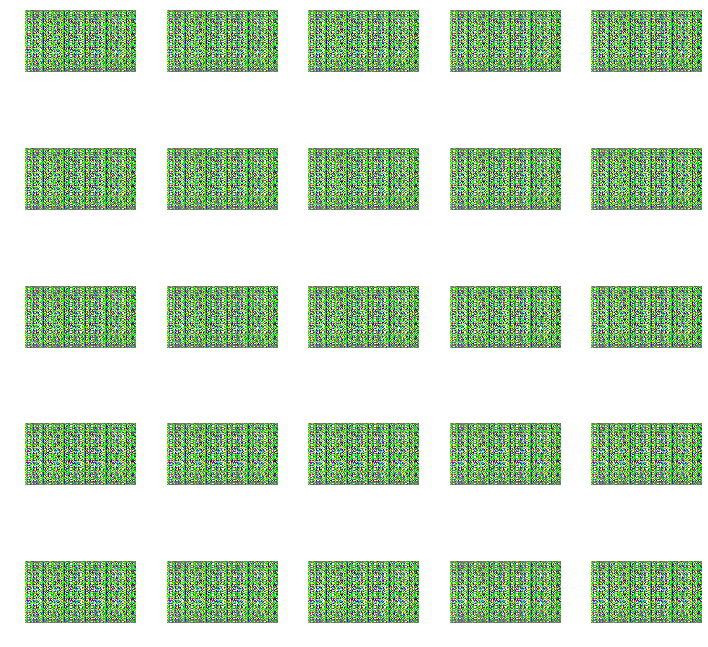

 13%|█▎        | 6298/50000 [3:26:35<23:42:32,  1.95s/it]

KeyboardInterrupt: 

In [15]:
train_gan(discriminator, gan, generator, losses, epoch_count = 50000, plot_frequency = 200, batch_size=32)

In [31]:
lr = gan.optimizer.lr = 1e3